In [1]:
pip install torchcp

  Obtaining dependency information for torchcp from https://files.pythonhosted.org/packages/ee/70/d4dae661050d6ddd7361a47b32af78bbeb402bd024b9e4c81d1359dc070f/torchcp-0.1.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/69.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/69.0 kB ? eta -:--:--
   ----- ---------------------------------- 10.2/69.0 kB ? eta -:--:--
   ----- ---------------------------------- 10.2/69.0 kB ? eta -:--:--
   ----- ---------------------------------- 10.2/69.0 kB ? eta -:--:--
   ----------------- ---------------------- 30.7/69.0 kB 119.1 kB/s eta 0:00:01
   ----------------- ---------------------- 30.7/69.0 kB 119.1 kB/s eta 0:00:01
   ----------------------- ---------------- 41.0/69.0 kB 122.9 kB/s eta 0:00:01
   ---------------------------------------- 69.0/69.0 kB 188.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/f9/e6/3c821e7417acd82df89e39f09156ce80d58817b5b4b1ac5453b522bc5dd4/torchvision-0.16.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.1 MB 109.5 kB/s eta 0:00:11
   - -------------------------------------- 0.0/1.1 MB 109.5 kB/s eta 0:00:11
   - -------------------------------------- 0.0/1.1 MB 109.3 kB/s eta 0:00:11
   - -------------------------------------- 0.0/1.1 MB 109.3 kB/s 

In [33]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor
from torchcp.classification.scores import THR, APS, RAPS, SAPS, Margin
from torchcp.utils import fix_randomness
from torchcp.classification.utils.metrics import Metrics

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Simple CNN model for demonstration purposes
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = torch.nn.Linear(14 * 14 * 32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 14 * 14 * 32)
        x = self.fc(x)
        return x

def test_fashionmnist():
    fix_randomness(seed=0)
    model_name = 'SimpleCNN'
    
    # Load or generate FashionMNIST dataset
    fashionmnist_test = FashionMNIST(root='./data', train=False, download=True, transform=transform)

    # Determine the length of the dataset
    dataset_length = len(fashionmnist_test)

    # Define the desired split lengths
    cal_length = int(0.8 * dataset_length)  # 80% for calibration
    test_length = dataset_length - cal_length  # Remaining 20% for testing

    # Perform the split
    cal_dataset, test_dataset = torch.utils.data.random_split(fashionmnist_test, [cal_length, test_length])

    model = SimpleCNN()
    model.to(device)

    cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=64, shuffle=True, pin_memory=True)
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
        
    # A standard process of conformal prediction
    alpha = 0.1
    predictors = [SplitPredictor, ClassWisePredictor, ClusterPredictor]
    score_functions = [THR(), APS(), RAPS(1, 0), SAPS(0.2), Margin()]
    
    for score in score_functions: 
        for class_predictor in predictors:
            predictor = class_predictor(score, model)
            predictor.calibrate(cal_data_loader, alpha)
            print(f"Experiment--Data : FashionMNIST, Model : {model_name}, Score : {score.__class__.__name__}, Predictor : {predictor.__class__.__name__}, Alpha : {alpha}")
            print(predictor.evaluate(test_data_loader))

In [34]:
test_fashionmnist()

Experiment--Data : FashionMNIST, Model : SimpleCNN, Score : THR, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.904, 'Average_size': 9.3645}
Experiment--Data : FashionMNIST, Model : SimpleCNN, Score : THR, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.9095, 'Average_size': 8.457}
Experiment--Data : FashionMNIST, Model : SimpleCNN, Score : THR, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.904, 'Average_size': 9.3595}
Experiment--Data : FashionMNIST, Model : SimpleCNN, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.897, 'Average_size': 9.1795}
Experiment--Data : FashionMNIST, Model : SimpleCNN, Score : APS, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.9025, 'Average_size': 8.349}
Experiment--Data : FashionMNIST, Model : SimpleCNN, Score : APS, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.8985, 'Average_size': 9.216}
Experiment--Data : FashionMNIST, Model : SimpleCNN, Score : RAPS

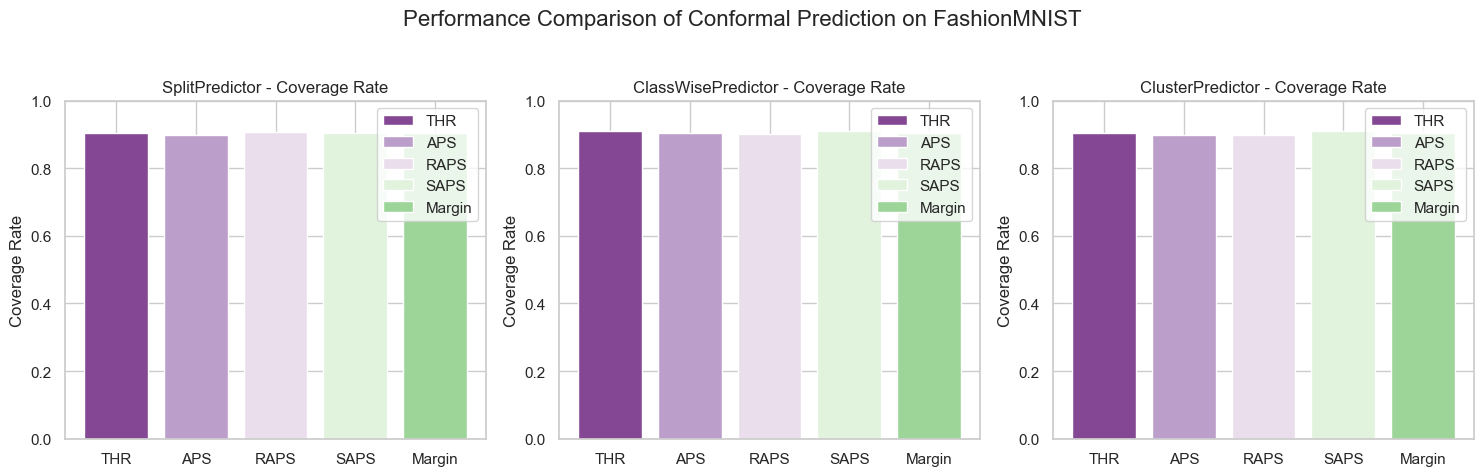

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# 设置 seaborn 风格
sns.set(style="whitegrid", palette="PRGn")

# 实验结果数据（这里只是一个示例）
data = {
    'SplitPredictor': {
        'THR': {'Coverage_rate': 0.904, 'Average_size': 9.3645},
        'APS': {'Coverage_rate': 0.897, 'Average_size': 9.1795},
        'RAPS': {'Coverage_rate': 0.907, 'Average_size': 9.204},
        'SAPS': {'Coverage_rate': 0.9025, 'Average_size': 9.2455},
        'Margin': {'Coverage_rate': 0.903, 'Average_size': 9.4665},
    },
    'ClassWisePredictor': {
        'THR': {'Coverage_rate': 0.9095, 'Average_size': 8.457},
        'APS': {'Coverage_rate': 0.9025, 'Average_size': 8.349},
        'RAPS': {'Coverage_rate': 0.9, 'Average_size': 8.2815},
        'SAPS': {'Coverage_rate': 0.9095, 'Average_size': 8.3665},
        'Margin': {'Coverage_rate': 0.904, 'Average_size': 8.4525},
    },
    'ClusterPredictor': {
        'THR': {'Coverage_rate': 0.904, 'Average_size': 9.3595},
        'APS': {'Coverage_rate': 0.8985, 'Average_size': 9.216},
        'RAPS': {'Coverage_rate': 0.897, 'Average_size': 9.1715},
        'SAPS': {'Coverage_rate': 0.9085, 'Average_size': 9.28},
        'Margin': {'Coverage_rate': 0.9035, 'Average_size': 9.4695},
    },
}

# 设置图表布局
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes = axes.flatten()

# 绘制Coverage Rate的比较图表
for i, (predictor, scores) in enumerate(data.items()):
    ax = axes[i]
    
    # 检查是否存在数据
    if not scores:
        ax.axis('off')  # 如果没有数据，关闭当前子图
        continue

    for score_name, score_data in scores.items():
        coverage_rate = score_data['Coverage_rate']
        ax.bar(score_name, coverage_rate, label=f'{score_name}')

    ax.set_title(f'{predictor} - Coverage Rate')
    ax.set_ylabel('Coverage Rate')
    ax.set_ylim(0, 1)

# 添加图例
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
axes[2].legend(loc='upper right')

# 设置整体图表标题
fig.suptitle('Performance Comparison of Conformal Prediction on FashionMNIST', fontsize=16)

# 调整布局
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [41]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10  # Import CIFAR10
from torchvision import transforms
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor
from torchcp.classification.scores import THR, APS, RAPS, SAPS, Margin
from torchcp.utils import fix_randomness
from torchcp.classification.utils.metrics import Metrics

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Simple CNN model for demonstration purposes
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=10):  # Adjust the number of classes for CIFAR-10
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = torch.nn.Linear(16 * 16 * 32, num_classes)  # Adjust the input size for CIFAR-10

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 16 * 16 * 32)
        x = self.fc(x)
        return x

def test_cifar10():
    fix_randomness(seed=0)
    model_name = 'SimpleCNN'
    
    # Load or generate CIFAR-10 dataset
    cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Determine the length of the dataset
    dataset_length = len(cifar10_test)

    # Define the desired split lengths
    cal_length = int(0.8 * dataset_length)  # 80% for calibration
    test_length = dataset_length - cal_length  # Remaining 20% for testing

    # Perform the split
    cal_dataset, test_dataset = torch.utils.data.random_split(cifar10_test, [cal_length, test_length])

    model = SimpleCNN(num_classes=10)  # Adjust the number of classes for CIFAR-10
    model.to(device)

    cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=64, shuffle=True, pin_memory=True)
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
        
    # A standard process of conformal prediction
    alpha = 0.1
    predictors = [SplitPredictor, ClassWisePredictor, ClusterPredictor]
    score_functions = [THR(), APS(), RAPS(1, 0), SAPS(0.2), Margin()]
    
    for score in score_functions: 
        for class_predictor in predictors:
            predictor = class_predictor(score, model)
            predictor.calibrate(cal_data_loader, alpha)
            print(f"Experiment--Data : CIFAR-10, Model : {model_name}, Score : {score.__class__.__name__}, Predictor : {predictor.__class__.__name__}, Alpha : {alpha}")
            print(predictor.evaluate(test_data_loader))

In [24]:
test_cifar10()

Files already downloaded and verified
Experiment--Data : CIFAR-10, Model : SimpleCNN, Score : THR, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.905, 'Average_size': 8.898}
Experiment--Data : CIFAR-10, Model : SimpleCNN, Score : THR, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.902, 'Average_size': 8.673}
Experiment--Data : CIFAR-10, Model : SimpleCNN, Score : THR, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.905, 'Average_size': 8.895}
Experiment--Data : CIFAR-10, Model : SimpleCNN, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.9, 'Average_size': 8.9795}
Experiment--Data : CIFAR-10, Model : SimpleCNN, Score : APS, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.9, 'Average_size': 8.762}
Experiment--Data : CIFAR-10, Model : SimpleCNN, Score : APS, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.9005, 'Average_size': 8.973}
Experiment--Data : CIFAR-10, Model : SimpleCNN, Score : RA

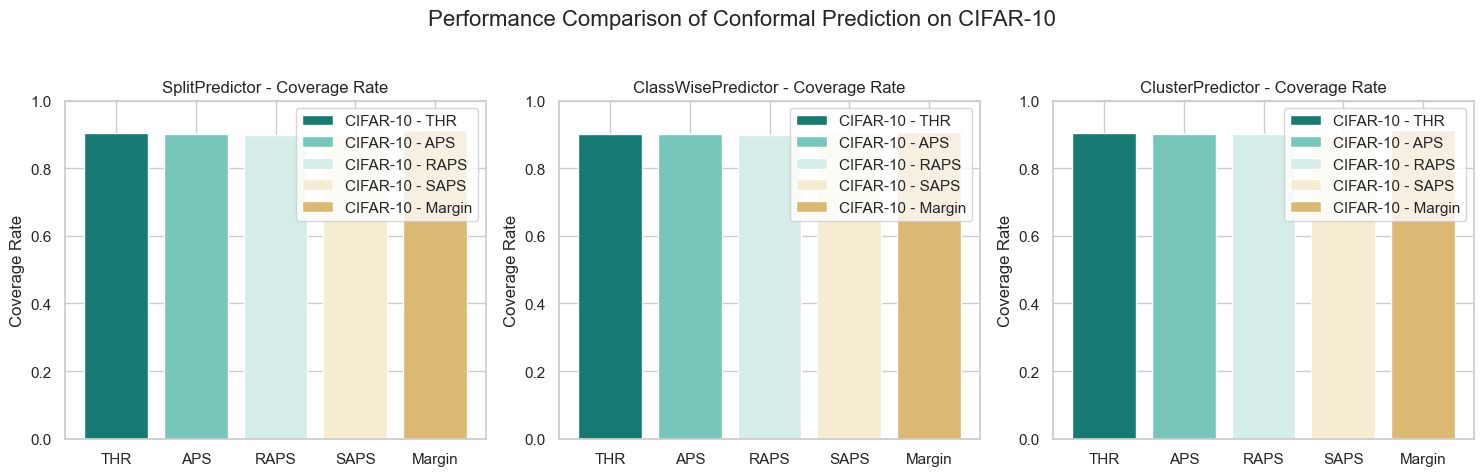

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns  # 添加 seaborn 库
import numpy as np

# 设置 seaborn 风格
sns.set(style="whitegrid", palette="BrBG_r")

# 实验结果数据（这里只是一个示例）
data_cifar10 = {
    'SplitPredictor': {
        'THR': {'Coverage_rate': 0.905, 'Average_size': 8.898},
        'APS': {'Coverage_rate': 0.9, 'Average_size': 8.9795},
        'RAPS': {'Coverage_rate': 0.8995, 'Average_size': 8.9665},
        'SAPS': {'Coverage_rate': 0.8995, 'Average_size': 8.967},
        'Margin': {'Coverage_rate': 0.914, 'Average_size': 9.0015},
    },
    'ClassWisePredictor': {
        'THR': {'Coverage_rate': 0.902, 'Average_size': 8.673},
        'APS': {'Coverage_rate': 0.9, 'Average_size': 8.762},
        'RAPS': {'Coverage_rate': 0.8975, 'Average_size': 8.767},
        'SAPS': {'Coverage_rate': 0.905, 'Average_size': 8.8025},
        'Margin': {'Coverage_rate': 0.907, 'Average_size': 8.7705},
    },
    'ClusterPredictor': {
        'THR': {'Coverage_rate': 0.905, 'Average_size': 8.895},
        'APS': {'Coverage_rate': 0.9005, 'Average_size': 8.973},
        'RAPS': {'Coverage_rate': 0.902, 'Average_size': 9.001},
        'SAPS': {'Coverage_rate': 0.9005, 'Average_size': 8.9805},
        'Margin': {'Coverage_rate': 0.914, 'Average_size': 9.002},
    },
}

# 设置图表布局
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes = axes.flatten()

# 绘制Coverage Rate的比较图表
for i, (predictor, scores) in enumerate(data_cifar10.items()):
    ax = axes[i]
    
    # 检查是否存在数据
    if not scores:
        ax.axis('off')  # 如果没有数据，关闭当前子图
        continue

    for score_name, score_data in scores.items():
        coverage_rate = score_data['Coverage_rate']
        ax.bar(score_name, coverage_rate, label=f'CIFAR-10 - {score_name}')

    ax.set_title(f'{predictor} - Coverage Rate')
    ax.set_ylabel('Coverage Rate')
    ax.set_ylim(0, 1)

# 添加图例
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
axes[2].legend(loc='upper right')

# 设置整体图表标题
fig.suptitle('Performance Comparison of Conformal Prediction on CIFAR-10', fontsize=16)

# 调整布局
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [29]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor
from torchcp.classification.scores import THR, APS, RAPS, SAPS, Margin
from torchcp.utils import fix_randomness
from torchcp.classification.utils.metrics import Metrics

# 数据集的预处理
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# 简单的 CNN 模型
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc = torch.nn.Linear(14 * 14 * 32, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 14 * 14 * 32)
        x = self.fc(x)
        return x

def test_mnist():
    fix_randomness(seed=0)
    model_name = 'SimpleCNN'
    
    # 加载 MNIST 数据集
    mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)

    # 确定数据集的长度
    dataset_length = len(mnist_test)

    # 定义所需的拆分长度
    cal_length = int(0.8 * dataset_length)  # 80% 用于校准
    test_length = dataset_length - cal_length  # 剩余 20% 用于测试

    # 执行拆分
    cal_dataset, test_dataset = torch.utils.data.random_split(mnist_test, [cal_length, test_length])

    model = SimpleCNN(num_classes=10)
    model.to(device)

    cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=64, shuffle=True, pin_memory=True)
    test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
        
    # CP的标准流程
    alpha = 0.1
    predictors = [SplitPredictor, ClassWisePredictor, ClusterPredictor]
    score_functions = [THR(), APS(), RAPS(1, 0), SAPS(0.2), Margin()]
    
    for score in score_functions: 
        for class_predictor in predictors:
            predictor = class_predictor(score, model)
            predictor.calibrate(cal_data_loader, alpha)
            print(f"Experiment--Data : MNIST, Model : {model_name}, Score : {score.__class__.__name__}, Predictor : {predictor.__class__.__name__}, Alpha : {alpha}")
            print(predictor.evaluate(test_data_loader))

# 在测试之前，确保将 "device" 设置为 "cuda:0" 或 "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
test_mnist()

Experiment--Data : MNIST, Model : SimpleCNN, Score : THR, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.8945, 'Average_size': 8.7055}
Experiment--Data : MNIST, Model : SimpleCNN, Score : THR, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.888, 'Average_size': 8.4925}
Experiment--Data : MNIST, Model : SimpleCNN, Score : THR, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.894, 'Average_size': 8.7005}
Experiment--Data : MNIST, Model : SimpleCNN, Score : APS, Predictor : SplitPredictor, Alpha : 0.1
{'Coverage_rate': 0.9055, 'Average_size': 8.7695}
Experiment--Data : MNIST, Model : SimpleCNN, Score : APS, Predictor : ClassWisePredictor, Alpha : 0.1
{'Coverage_rate': 0.902, 'Average_size': 8.818}
Experiment--Data : MNIST, Model : SimpleCNN, Score : APS, Predictor : ClusterPredictor, Alpha : 0.1
{'Coverage_rate': 0.907, 'Average_size': 8.795}
Experiment--Data : MNIST, Model : SimpleCNN, Score : RAPS, Predictor : SplitPredictor, Alpha : 0.1
{'Cover

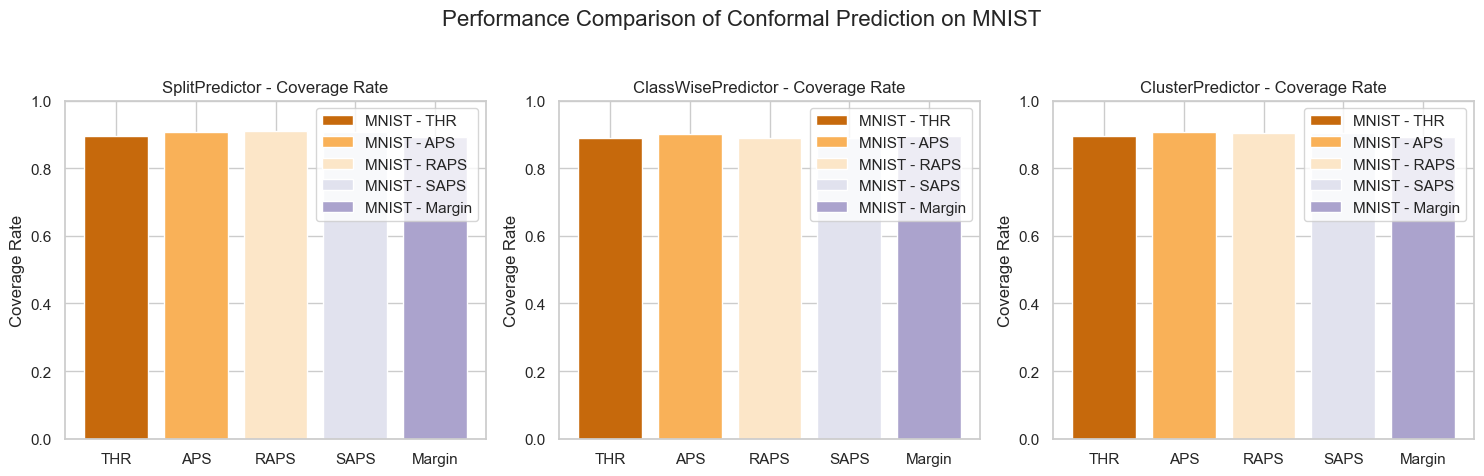

In [49]:
# 设置 seaborn 风格
sns.set(style="whitegrid", palette="PuOr")

# 实验结果数据（MNIST）
data_mnist = {
    'SplitPredictor': {
        'THR': {'Coverage_rate': 0.8945, 'Average_size': 8.7055},
        'APS': {'Coverage_rate': 0.9055, 'Average_size': 8.7695},
        'RAPS': {'Coverage_rate': 0.911, 'Average_size': 8.7665},
        'SAPS': {'Coverage_rate': 0.9075, 'Average_size': 8.785},
        'Margin': {'Coverage_rate': 0.8915, 'Average_size': 8.896},
    },
    'ClassWisePredictor': {
        'THR': {'Coverage_rate': 0.888, 'Average_size': 8.4925},
        'APS': {'Coverage_rate': 0.902, 'Average_size': 8.818},
        'RAPS': {'Coverage_rate': 0.8885, 'Average_size': 8.786},
        'SAPS': {'Coverage_rate': 0.889, 'Average_size': 8.795},
        'Margin': {'Coverage_rate': 0.894, 'Average_size': 8.714},
    },
    'ClusterPredictor': {
        'THR': {'Coverage_rate': 0.894, 'Average_size': 8.7005},
        'APS': {'Coverage_rate': 0.907, 'Average_size': 8.795},
        'RAPS': {'Coverage_rate': 0.9025, 'Average_size': 8.7385},
        'SAPS': {'Coverage_rate': 0.9035, 'Average_size': 8.797},
        'Margin': {'Coverage_rate': 0.8915, 'Average_size': 8.896},
    },
}

# 设置图表布局
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes = axes.flatten()

# 绘制 Coverage Rate 的比较图表
for i, (predictor, scores) in enumerate(data_mnist.items()):
    ax = axes[i]

    # 检查是否存在数据
    if not scores:
        ax.axis('off')  # 如果没有数据，关闭当前子图
        continue

    for score_name, score_data in scores.items():
        coverage_rate = score_data['Coverage_rate']
        ax.bar(score_name, coverage_rate, label=f'MNIST - {score_name}')

    ax.set_title(f'{predictor} - Coverage Rate')
    ax.set_ylabel('Coverage Rate')
    ax.set_ylim(0, 1)

# 添加图例
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')
axes[2].legend(loc='upper right')

# 设置整体图表标题
fig.suptitle('Performance Comparison of Conformal Prediction on MNIST', fontsize=16)

# 调整布局
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
